<img src='https://gitlab.eumetsat.int/eumetlab/oceans/ocean-training/tools/frameworks/-/raw/main/img/Standard_banner.png' align='right' width='100%'/>

<a href="../Index.ipynb"><< Index</a>
<br>
<a href="./1_5_SLSTR_radiance_BT_spectra.ipynb"><< SLSTR radiance and brightness temperature spectra</a>

<font color="#138D75">**Copernicus Marine Training Service**</font> <br>
**Copyright:** 2022 EUMETSAT <br>
**License:** MIT

<div class="alert alert-block alert-success">
<h3>Learn SLSTR: Introductory</h3></div>

<div class="alert alert-block alert-warning">
    
<b>PREREQUISITES </b>
    
The following modules are prerequisites for this notebook, and will retrieve the data required here.
  - **<a href="./1_1a_SLSTR_data_access_Data_Store.ipynb" target="_blank">1_1a_SLSTR_data_access_Data_Store.ipynb</a>** if using the Data Store for data access
    <br><br>**OR**<br><br>
  - **<a href="./1_1b_SLSTR_data_access_HDA.ipynb" target="_blank">1_1b_SLSTR_data_access_HDA.ipynb</a>** if using WEkEO for data access
    
</div>
<hr>

# 1.6 Using SLSTR sea surface temperature products


### Data used

| Product Description | Data Store collection ID| Product Navigator | WEkEO HDA ID | WEkEO metadata |
|:--------------------:|:-----------------------:|:-------------:|:-----------------:|:-----------------:|
| Sentinel-3 SLSTR level-2 (NTC) | EO:EUM:DAT:0412 | <a href="https://navigator.eumetsat.int/product/EO:EUM:DAT:SENTINEL-3:SL_2_WST___NTC?query=0412&s=advanced" target="_blank">link</a> | EO:EUM:DAT:SENTINEL-3:SL_2_WST___ | <a href="https://www.wekeo.eu/data?view=dataset&dataset=EO%3AEUM%3ADAT%3ASENTINEL-3%3ASL_2_WST___&initial=1" target="_blank">link</a> |


### Learning outcomes

At the end of this notebook you will know;
* A bit about using and defining functions in Python and Jupyter Notebooks.
* About the sea surface temperature (SST) products available from SLSTR.
* How to plot SST data on maps.
* How SST data is produced using multiple retrieval algorithms.
* The utility of error statistics.
* About quality levels and flags.
* How to apply information from error statistics, quality levels, and flags, to extract and visualise the highest quality data.


### Outline

One of the main objectives of the Sentinel-3 mission is the delivery of sea surface temperature measurements. The Sea and Land Surface Temperature Radiometer (SLSTR) measures the electromagnetic radiation emitted by the sea surface, at various wavelengths. This data can then be combined, using a variety of methods (known as 'retrieval algorithms') to convert the measurements in to the geophysical values of temperature. For the SST data to be useful, estimates of error, as well as indicators of quality, can help users decide how valid the data is for their particular application. This notebook explains how retrieval algorithms work, and how to apply the supporting quality information to SST data from SLSTR.


<div class="alert alert-info" role="alert">

## <a id='TOC_TOP'></a>Contents

</div>

 0. [A quick preamble on functions](#section0)
 1. [SLSTR SST products](#section1)
 2. [Reading SLSTR SST data](#section2)
 3. [Plotting SST data](#section3)
 4. [Understanding retrieval algorithms](#section4)
 5. [Understanding single sensor error statistics](#section5)
 6. [Understanding quality levels and applying flags](#section6)
 7. [Bringing it all togethers](#section7)

<hr>

Let's begin by importing all the Python libraries we need for this notebook.

In [1]:
# library imports
import cartopy                               # a library that support mapping
from cartopy.feature.nightshade import Nightshade # a library that helps plot day/night cycles
import datetime                              # a library that supports time and dat objects
import glob                                  # a library that aids in searching for files
import matplotlib.pyplot as plt              # a library that support plotting
import matplotlib.ticker as mticker          # a library that extends plotting support
from matplotlib.colors import ListedColormap # a library that extends plotting support
import numpy as np                           # a library that provides support for array-based mathematics
import os                                    # a library that allows us access to basic operating system commands like making directories
import warnings                              # a library that helps us manage warnings
import xarray as xr                          # a library that supports the use of multi-dimensional arrays in Python
import xml.etree.ElementTree as ET           # a library that helps us parse XML files
import eumartools                            # a EUMETSAT library that support working with Sentinel-3 products
warnings.filterwarnings('ignore')

# set plot font size
plt.rcParams.update({'font.size': 12})

# define a discrete colourmap for later use
cmap = ListedColormap(['0.75', '#B03A2E', '#F39C12', '#F1C40F', '#5DADE2', '#1F618D'])

<div class="alert alert-warning" role="alert">

## <a id='section0'></a>0. A quick preamble on functions
[Back to top](#TOC_TOP)

</div>

In this notebook we will define a simple function `slstr_plot`, which can be called throughout the notebook. We do this, so that we can use the same piece of code multiple times without re-writing it.

In [2]:
# define a quick function to save us time throughout this notebook
def slstr_plot(m, band_vars, var, limits, lon="lon", lat="lat", cmap=plt.cm.RdBu_r):
    """Function to plot SLSTR data and embellish with gridlines and labels

    Args:
        m (axis):                   the axis to plot into
        band_vars (xarray Dataset): the variable containing the data
        limits (list):              min x, max x, min y, max y, vmin, vmax
        lon (str):                  the longitude variables in band_vars
        lat (str):                  the latitude variables in band_vars
        cmap (colormap):            the colormap to use in the plot

    Returns:
        if successful, returns p1, the pcolormesh plot instance.

    """
    minx, maxx, miny, maxy, vmin, vmax = limits
    p1 = m.pcolormesh(np.squeeze(band_vars[lon][miny:maxy,minx:maxx]),
                      np.squeeze(band_vars[lat][miny:maxy,minx:maxx]),
                      var,
                      transform=cartopy.crs.PlateCarree(central_longitude=0.0), 
                      cmap=cmap, zorder=1, vmin=vmin, vmax=vmax)

    # Embellish with gridlines
    g1 = m.gridlines(draw_labels = True, zorder=20, color='0.0', linestyle='--',linewidth=0.5)
    g1.xlocator = mticker.FixedLocator(np.arange(-180, 180, 5))
    g1.ylocator = mticker.FixedLocator(np.arange(-90, 90, 5))
    g1.top_labels = False
    g1.right_labels = False
    g1.xlabel_style = {'color': 'black'}
    g1.ylabel_style = {'color': 'black'}
    m.set(facecolor = "1.0")
    m.axis('off')
    
    return p1

<div class="alert alert-info" role="alert">

## <a id='section1'></a>1. SLSTR sea-surface temperature products and algorithms
[Back to top](#TOC_TOP)

</div>

Measuring sea surface temperature requires a definition of what 'surface' actually means. In practice, the scientific community (particularly the <a href="https://www.ghrsst.org/" target="_blank"> Group for High Resolution SST (GHRSST)</a>) has defined several measurements of SST as shown in the Figure 1.

<img src='https://www.ghrsst.org/wp-content/uploads/2021/04/newerSSTdef.gif' align='centre' width='75%'></img>
<center>Figure 1: Sea surface temperature definitions (courtesy: GHRSST)</center>

Infrared radiometers, such as SLSTR, measure *SSTskin*, the sea surface skin temperature at ~10 $\mu$m depth. It is clear from the picture above that, at night or when there are strong winds, this temperature may differ from the *SSTdepth* or *SSTfnd* that typically may measure from *in situ* sensors by only a small amount. However, during the day and where there is little mechanical mixing from light winds, this is not the case, and the difference between *SSTskin* and *SSTdepth* can be very large.

<div class="alert alert-info" role="alert">

## <a id='section2'></a>2. Reading SLSTR SST data
[Back to top](#TOC_TOP)

</div>

First we define the directory that contains our product of interest, a level-2 SLSTR WST product.

In [3]:
SAFE_directory = os.path.join(os.getcwd(), 'products',
    'S3A_SL_2_WST____20220209T213232_20220209T231332_20220211T074946_6059_081_385______MAR_O_NT_003.SEN3')

The SAFE folder for a SLSTR WST products contains only a single netCDF file that contains all the variables we need. We can open this easily using a single line using `xarray`.

In [4]:
band_vars = xr.open_mfdataset(glob.glob(os.path.join(SAFE_directory,'*.nc')))
band_vars.close()

Lets also find the XML manifest file for this product

In [5]:
# selecting SAFE manifest
SAFE_manifest = glob.glob(os.path.join(SAFE_directory, 'xfd*.xml'))[0]

<div class="alert alert-info" role="alert">

## <a id='section3'></a>3. Plotting SST data
[Back to top](#TOC_TOP)

</div>

Lets start by plotting the full extent of our sea surface temperature (SST) data. We are working with a non-time critical (NT) product, for which the product dissemination unit (PDU) is a full orbit. You can find more information on this in the **<a href="./1_3_SLSTR_coverage.ipynb">Determining SLSTR product coverage >></a>** notebook.

To save some time with plotting we will reduce the resolution of the product. The `grid_reduce` parameter will sub-sample the SST product in each dimension. If you have enough memory, or are working with smaller products, you can lower this number. A value of "1" will give you the full resolution. 

In [6]:
# grid sub-sampling parameter
grid_reduce = 5

# Kelvin to Celsius conversion
k_to_c = 273.15

Next we will read the acquisition start and stop time from the manifest file. From this we will calculate the average time of the orbital pass, which will be useful later.

In [7]:
tree = ET.parse(SAFE_manifest)
root = tree.getroot()
acq_start = root.findall('.//sentinel-safe:startTime', {'sentinel-safe':'http://www.esa.int/safe/sentinel/1.1'})
acq_stop = root.findall('.//sentinel-safe:stopTime', {'sentinel-safe':'http://www.esa.int/safe/sentinel/1.1'})
t1 = datetime.datetime.strptime(acq_start[0].text, "%Y-%m-%dT%H:%M:%S.%fZ")
t2 = datetime.datetime.strptime(acq_stop[0].text, "%Y-%m-%dT%H:%M:%S.%fZ")
avg_date = t1 + (t2-t1)/2

Now we will make our plot. The box below looks complex as it performs a few operations; defining our figure, modifying the longitude to enable better plotting, making the SST plot, and finally embellishing it with gridlines and colourbars.

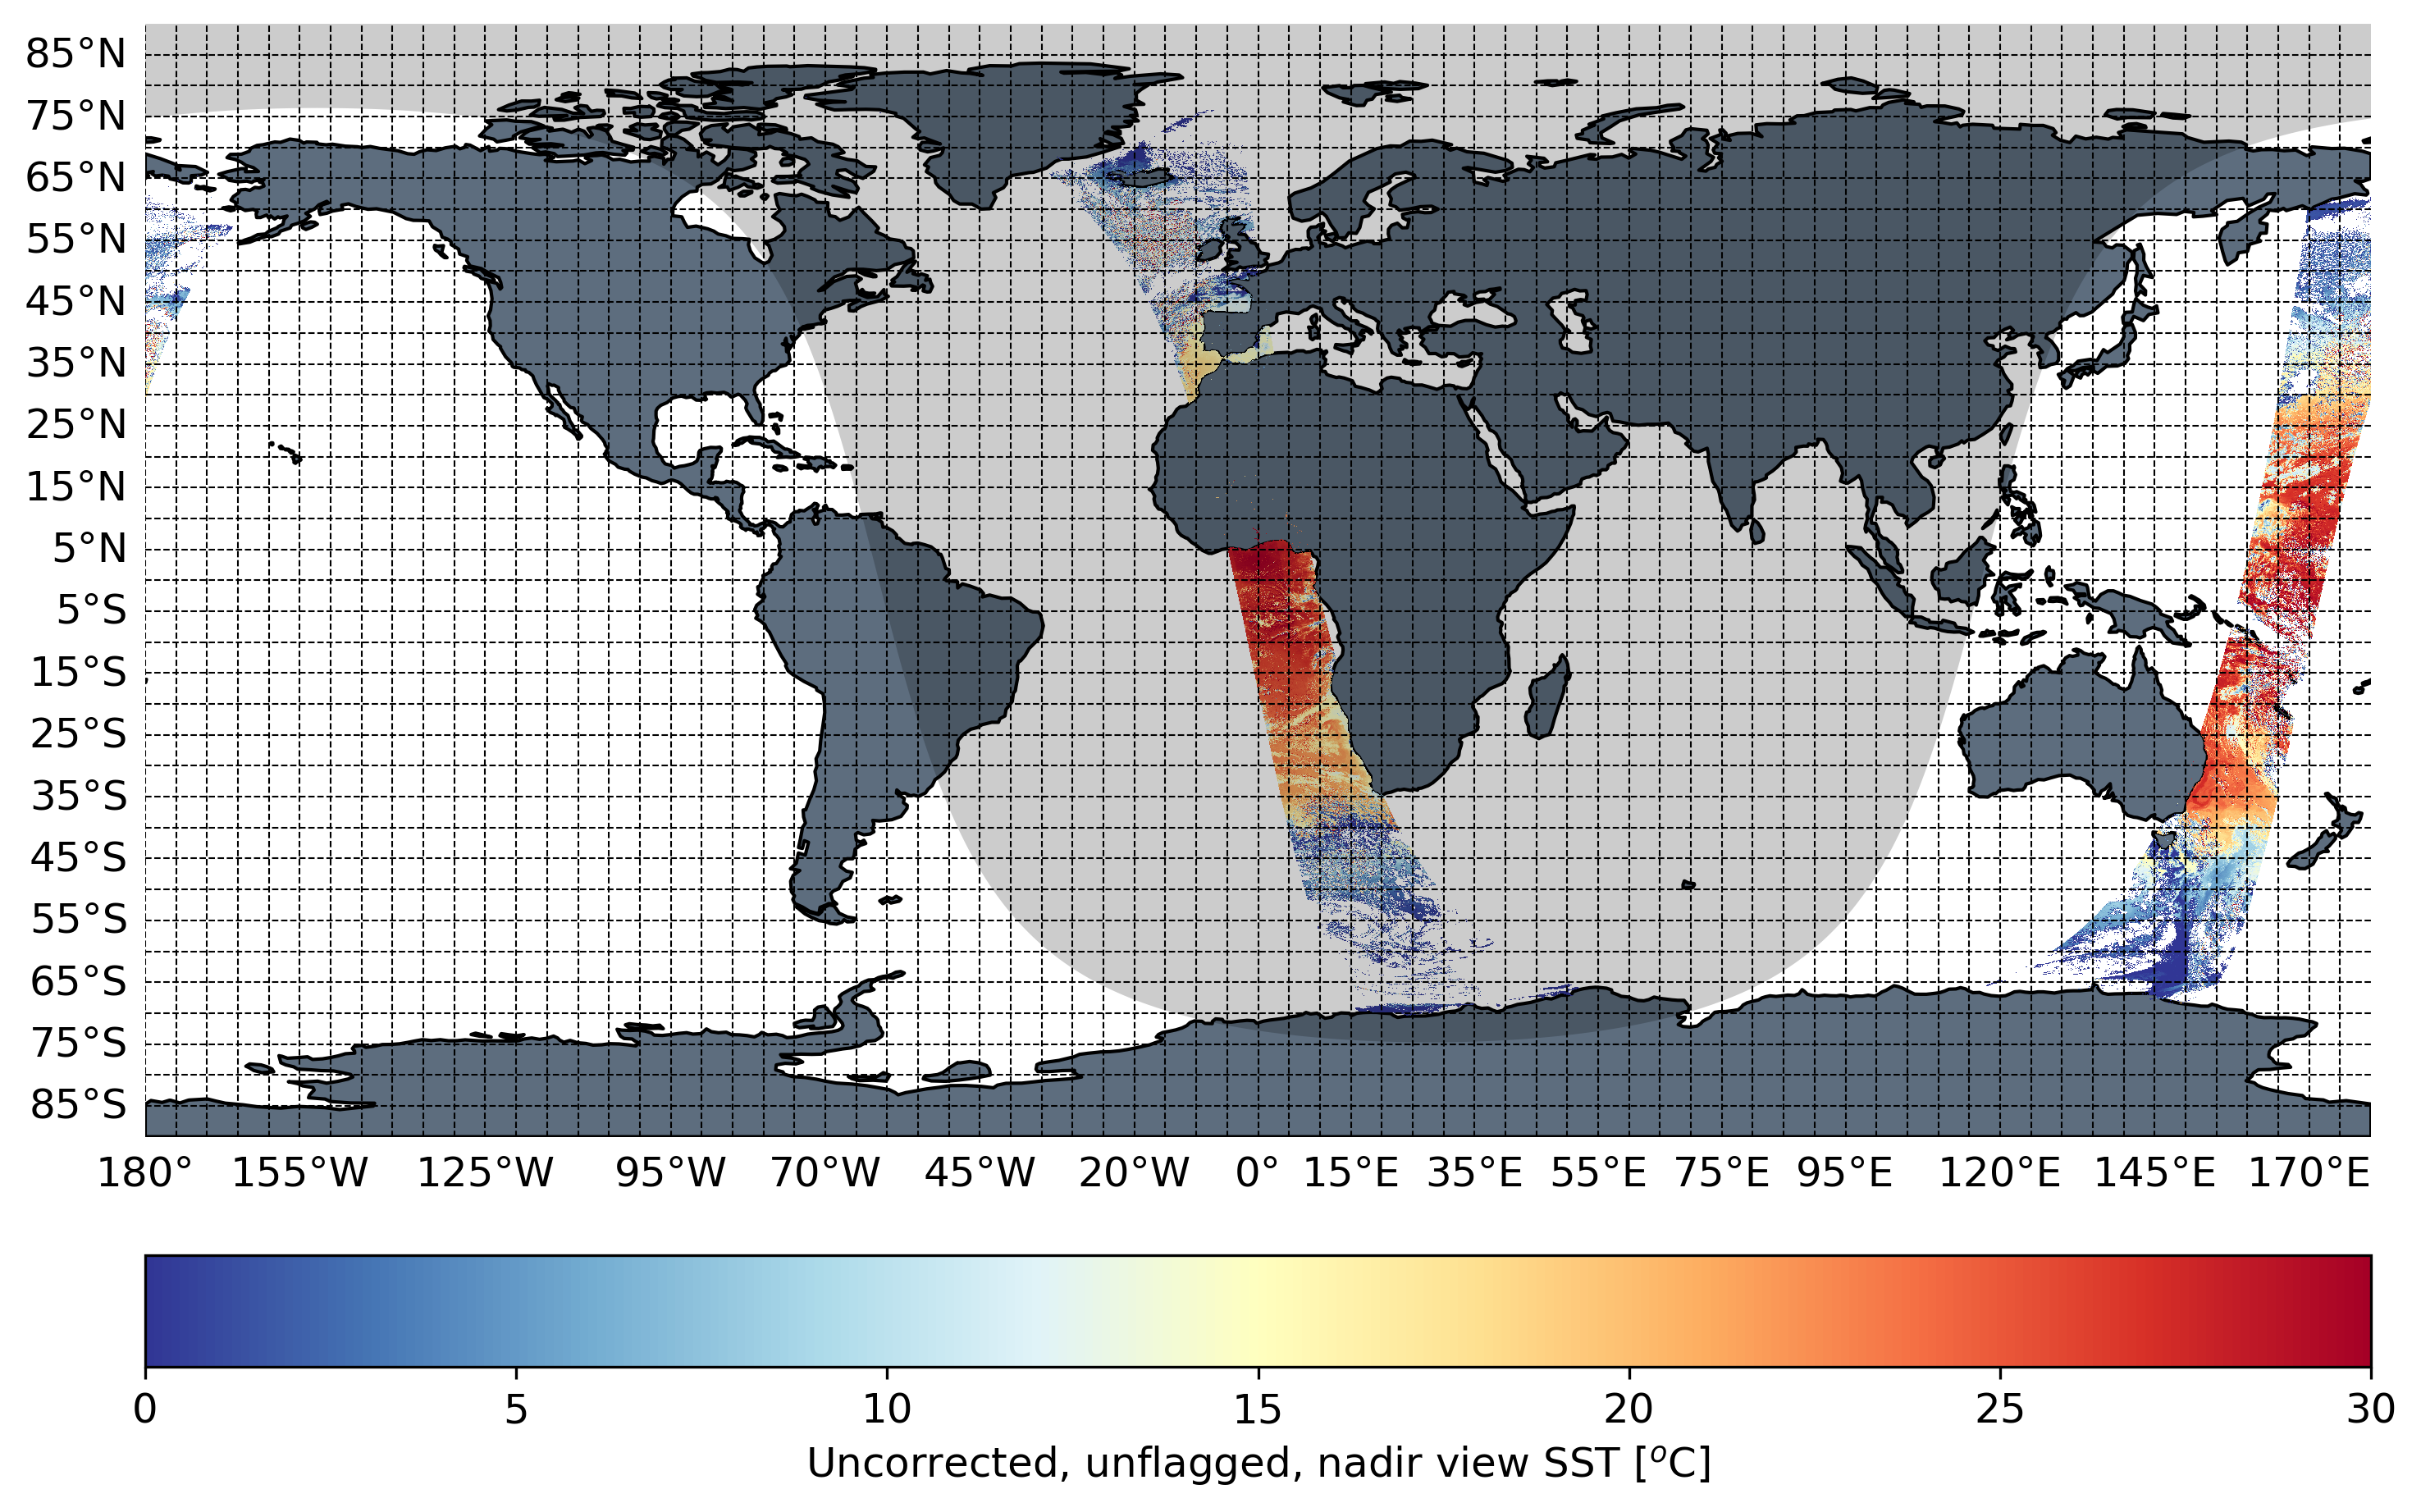

In [8]:
# define the figure
fig = plt.figure(figsize=(10, 10), dpi=300)
m = plt.subplot(projection=cartopy.crs.PlateCarree())
m.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='k', facecolor='#5D6D7E')
m.set_global()

# issues with +/- 180 unless you do this.
shift_lon = np.array(band_vars["lon"][::grid_reduce, ::grid_reduce])
ii = np.where(shift_lon < 0.0)
shift_lon[ii] = shift_lon[ii] + 360.0

# make the plot itself
p1 = m.pcolormesh(shift_lon, band_vars["lat"][::grid_reduce, ::grid_reduce],
                  band_vars["sea_surface_temperature"][0, ::grid_reduce, ::grid_reduce] - k_to_c,
                  transform=cartopy.crs.PlateCarree(central_longitude=0.0), 
                  cmap=plt.cm.RdYlBu_r, zorder=1, vmin=0, vmax=30)

# Embellish with gridlines
g1 = m.gridlines(draw_labels = True, zorder=20, color='0.0', linestyle='--',linewidth=0.5)
g1.xlocator = mticker.FixedLocator(np.arange(-180, 180, 5))
g1.ylocator = mticker.FixedLocator(np.arange(-90, 90, 5))
g1.top_labels = False
g1.right_labels = False
g1.xlabel_style = {'color': 'black'}
g1.ylabel_style = {'color': 'black'}
m.set(facecolor = "1.0")
m.axis('off')

# set the "night shadow"
m.add_feature(Nightshade(avg_date, alpha=0.2))

# create the colour bar
cbar = fig.colorbar(p1, location='bottom', pad=0.05)
cbar.set_label('Uncorrected, unflagged, nadir view SST [$^{o}$C]')
plt.tight_layout()

Here we have our first full-orbit plot of bias-uncorrected, nadir view SST with no flagging applied. Later on in this notebook we will consider how to correct for bias, isolate only the dual view SST and apply quality flags. First, though, lets zoom in on a two areas; the Gulf of Cadiz and the East Australian Current. We define regions of interest (ROIs) for these below.

In [9]:
# look at two smaller areas; Gulf of Cadiz (GoC) and East Australian Current (EAC)
coords = {}
coords["GoC"] = {}
coords["GoC"]["name"] = "Gulf of Cadiz"
coords["GoC"]["lons"] = [-10.0, 0.0,  0.0, -10.0, -10.0]
coords["GoC"]["lats"] = [30.0, 30.0, 40.0,  40.0,  30.0]

coords["EAC"] = {}
coords["EAC"]["name"] = "East Australian Current"
coords["EAC"]["lons"] = [150.0, 160.0, 160.0, 150.0, 150.0]
coords["EAC"]["lats"] = [-37.5, -37.5, -27.5, -27.5, -37.5]

The box below will extract the x and y point indices of the corners of the boxes we defined above. This will enable us to "zoom in" on our ROIs when plotting.

In [10]:
for item in coords:
    coords[item]["x"], coords[item]["y"], mask = eumartools.subset_image(np.array(band_vars["lon"]),
                                                                         np.array(band_vars["lat"]),
                                                                         coords[item]["lons"],
                                                                         coords[item]["lats"])

Now we can make smaller plots of our ROIs. This will help us look at some specific structures as well as highlight more clearly some issues with the data that we need to address.

Plotting Gulf of Cadiz
Plotting East Australian Current


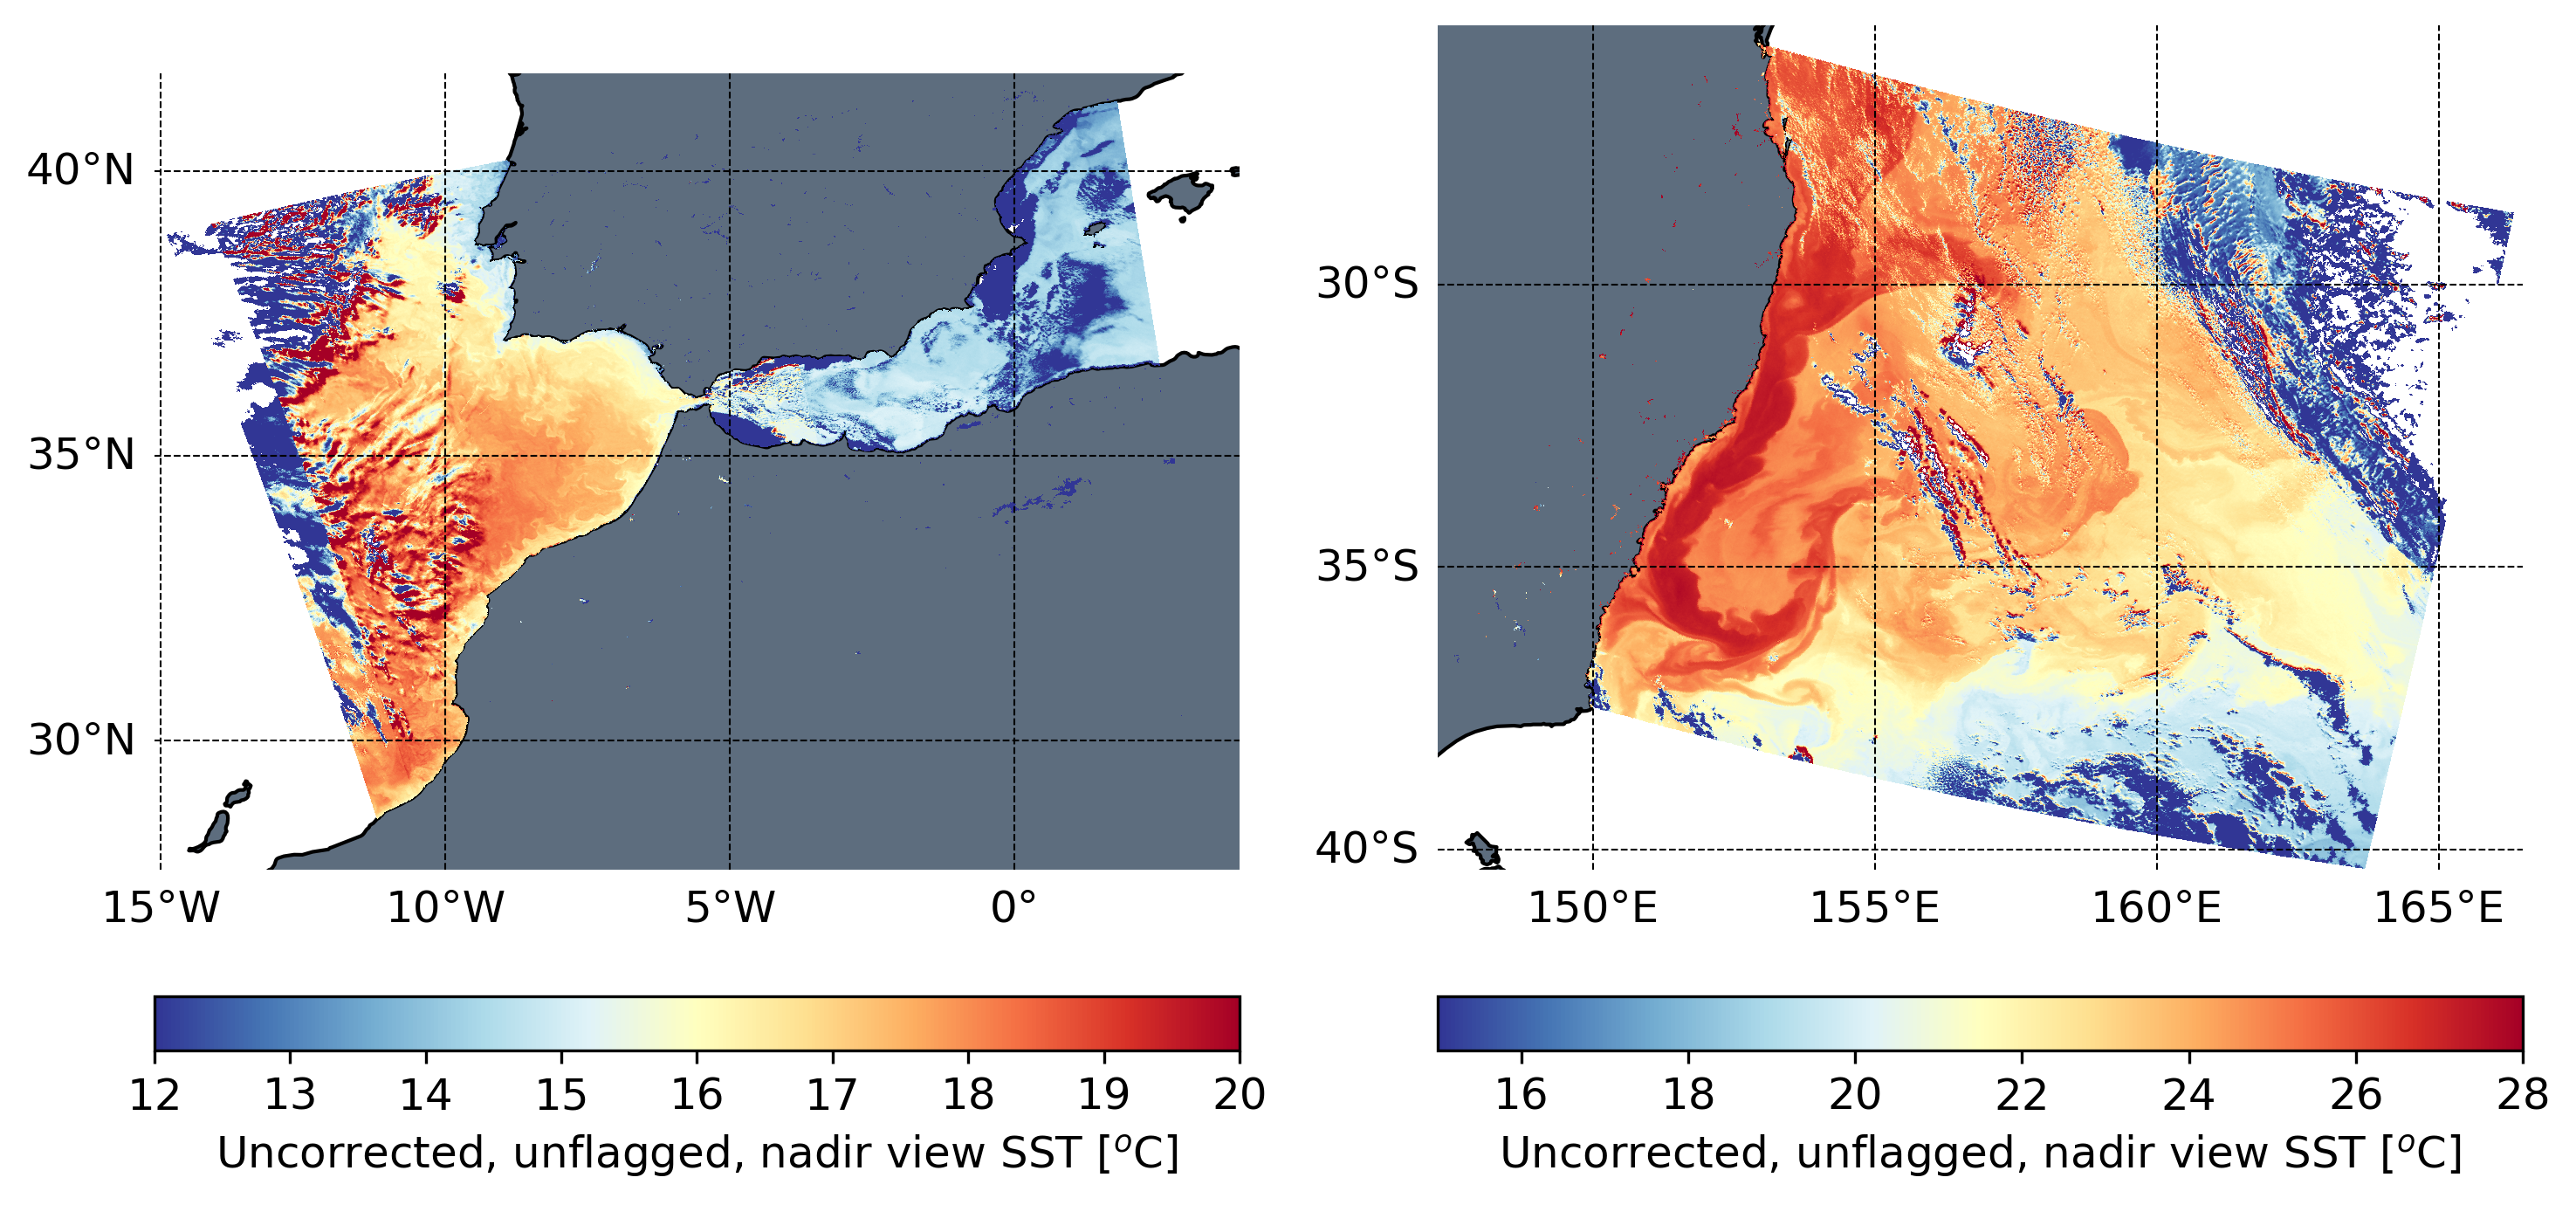

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(10, 10), dpi=300, subplot_kw={"projection": cartopy.crs.PlateCarree()})

for m, loc, vmin, vmax in zip(axs, coords, [12, 15], [20, 28]):
    print(f"Plotting {coords[loc]['name']}")
    
    # setting "x" to use full swath width
    minx = 0 ; maxx = np.shape(band_vars["lon"])[-1]
    miny = min(coords[loc]["y"]) ; maxy = max(coords[loc]["y"])
    
    m.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='k', facecolor='#5D6D7E')
    pvar = band_vars["sea_surface_temperature"][0, miny:maxy, minx:maxx] - k_to_c
    p1 = slstr_plot(m, band_vars, pvar, [minx, maxx, miny, maxy, vmin, vmax], cmap=plt.cm.RdYlBu_r)

    cbar = fig.colorbar(p1, ax=m, location='bottom', pad=0.05)
    cbar.set_label('Uncorrected, unflagged, nadir view SST [$^{o}$C]')

plt.tight_layout()

In the left hand panel we can see the night-time SST view of the Gulf of Cadiz. We can see some clear differences in the temperature of the Mediterranean as compared to the North Atlantic, as well as some coastal filaments South West of the Straits of Gibraltar and coastal upwelling in the Gulf of Cadiz itself and along coastal Spain. However, we can also clearly see that there are some anomalous "cold patches" in the image, as well as some strange behaviour on the western edge of the swath. There is work to be done addressing these.

In the right hand panel we can see a beautiful day-time SST view of the warm western boundary current waters of East Australian Current. We can see eddies and filaments all along the current, whose temperature contrasts with the cooler offshore environment. However, again we see some "scratchy" warm/cold patches across the image, again implying that we need to look at the quality of the image.

<div class="alert alert-info" role="alert">

## <a id='section4'></a>4. Understanding retrieval algorithms
[Back to top](#TOC_TOP)

</div>

SLSTR has 5 retrieval algorithms for sea surface temperature. The algorithms are named for the viewing geometry they use, as well as the number of brightness temperature bands they use. Consequently, we have;
* N2 - which uses only the nadir view and the S8 and S9 channels.
* N3 - which uses only the nadir view and the S7, S8 and S9 channels.
* N3R - which uses only the nadir view and the S7, S8 and S9 channels, and is designed for regions with high aerosol content.
* D2 - which uses the nadir and oblique **dual** views and the S8 and S9 channels.
* D3 - which uses the nadir and oblique **dual** views and the S7, S8 and S9 channels.

We can see what algorithms were used to retrieve the SST across our regions of interest. We will plot these using the code in the box below.

Plotting Gulf of Cadiz
Plotting East Australian Current


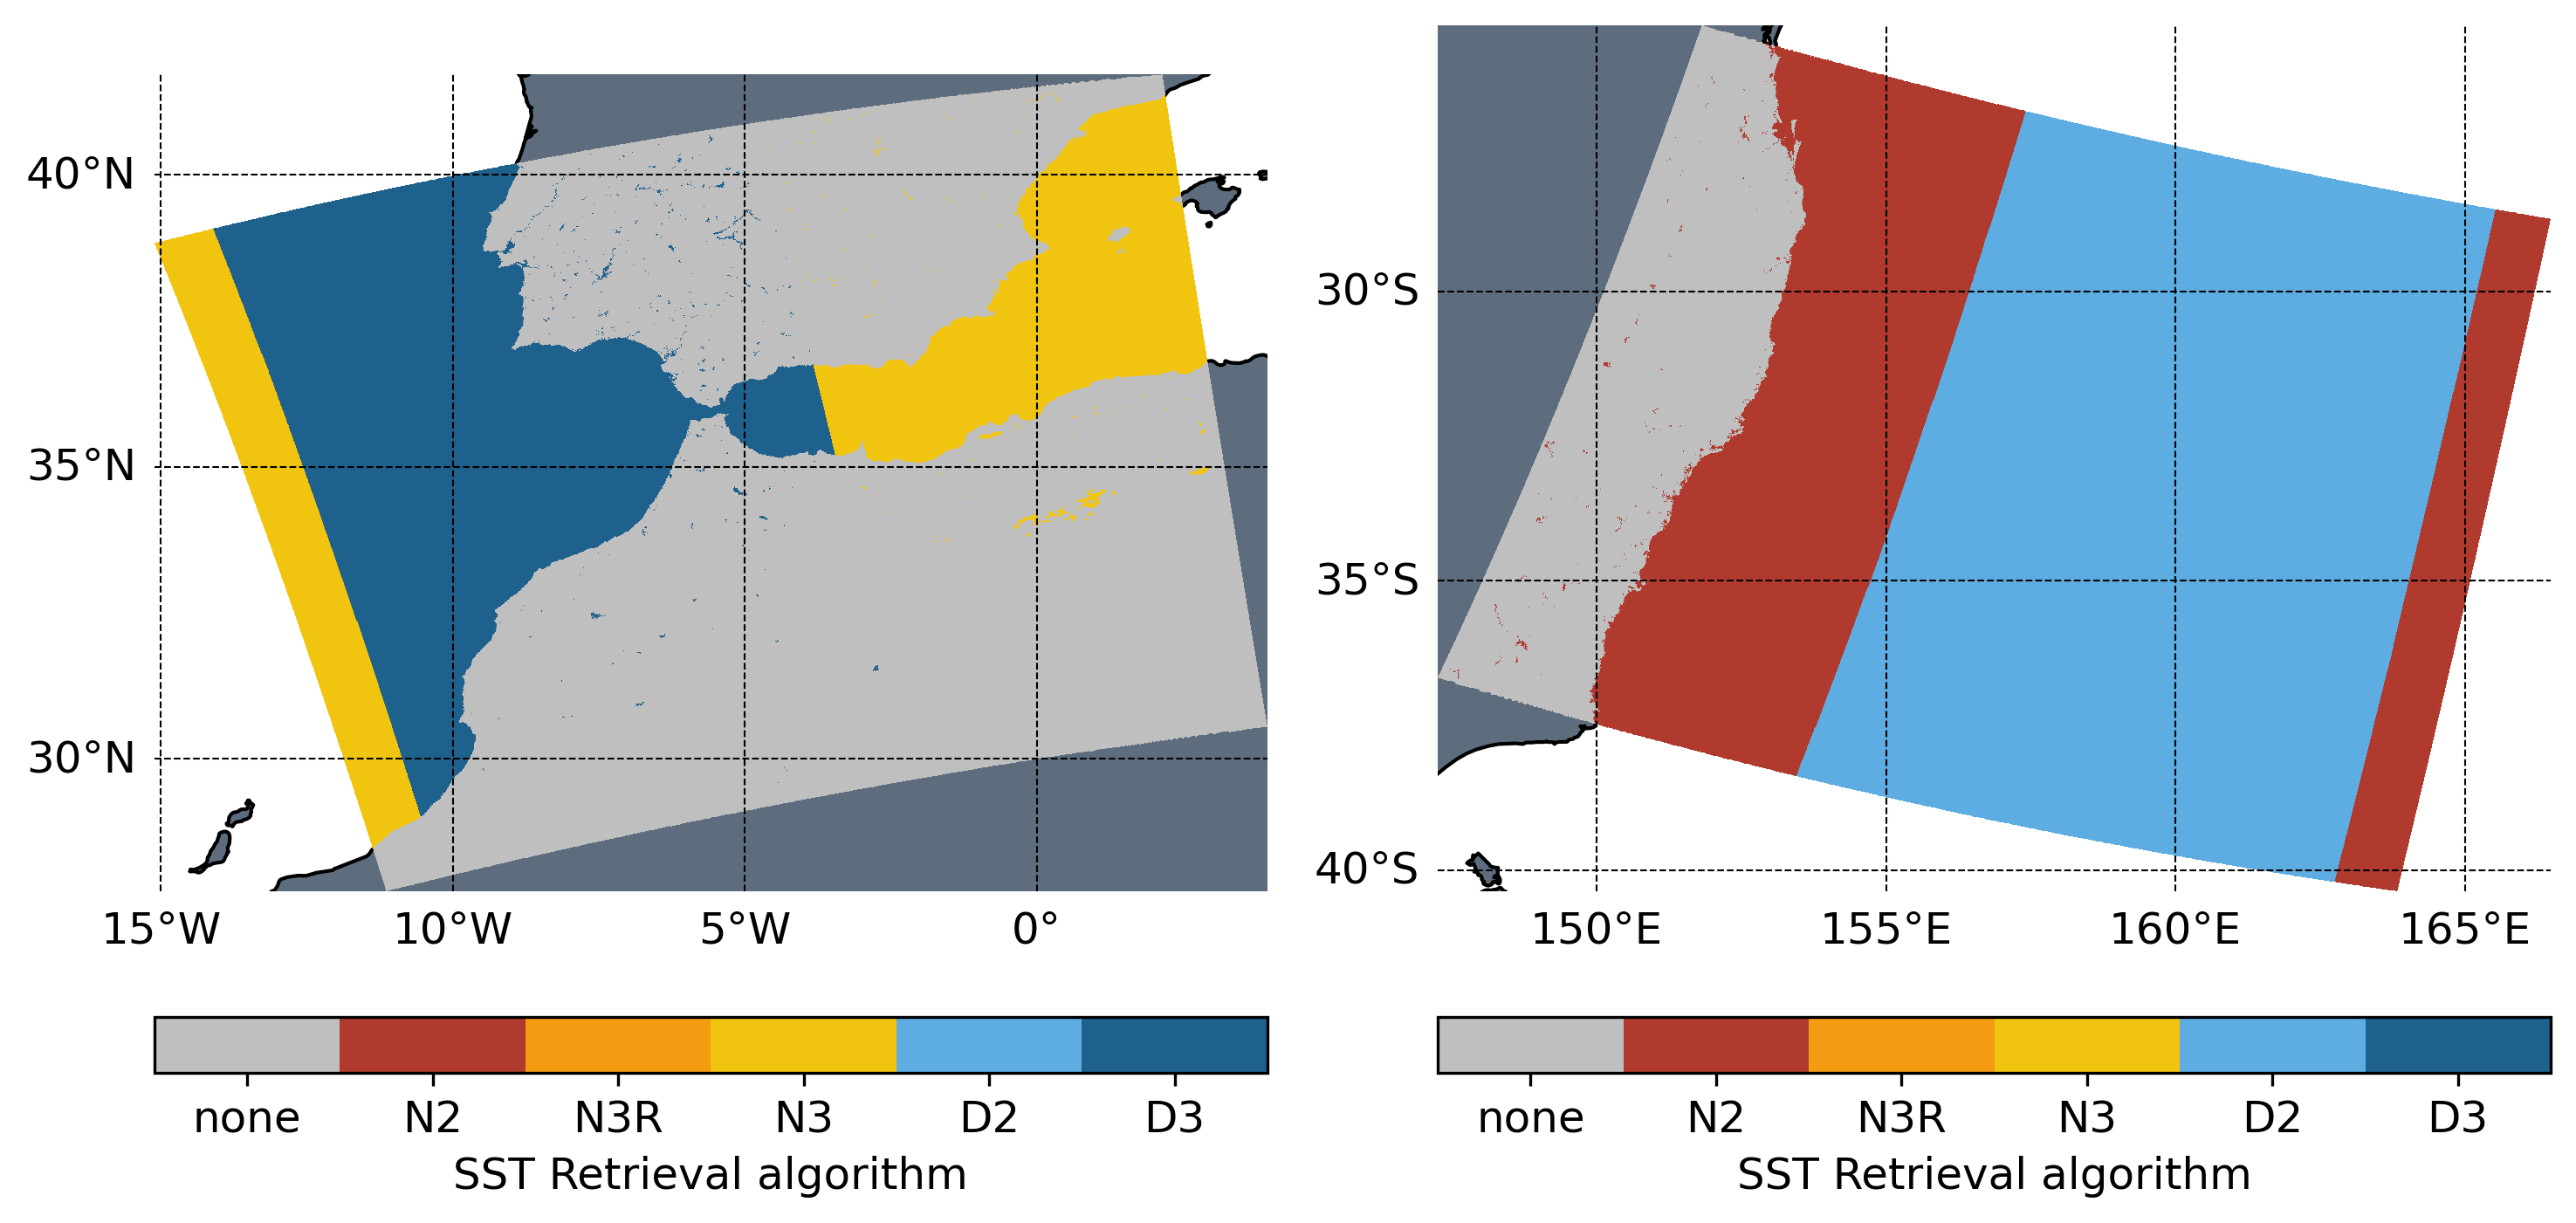

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(10, 10), dpi=300, subplot_kw={"projection": cartopy.crs.PlateCarree()})

for m, loc, vmin, vmax in zip(axs, coords , [0, 0], [6, 6]):
    print(f"Plotting {coords[loc]['name']}")

    # setting "x" to use full swath width
    minx = 0 ; maxx = np.shape(band_vars["lon"])[-1]
    miny = min(coords[loc]["y"]) ; maxy = max(coords[loc]["y"])
    
    m.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='k', facecolor='#5D6D7E')
    pvar = band_vars["sst_algorithm_type"][0, miny:maxy, minx:maxx]
    p1 = slstr_plot(m, band_vars, pvar, [minx, maxx, miny, maxy, vmin, vmax], cmap=cmap)

    cbar = fig.colorbar(p1, ax=m, location='bottom', pad=0.05)
    cbar.set_label('SST Retrieval algorithm')
    cbar.set_ticks([0.5, 1.5, 2.5, 3.5, 4.5, 5.5])
    cbar.set_ticklabels(['none', 'N2', 'N3R', 'N3', 'D2', 'D3'])
    
plt.tight_layout()

We know, from previous notebooks that the S7 channel becomes contaminated by solar reflectance in the day. Therefore, we use the N3 and D3 algorithms at night (as seen on the left across the GoC), and the N2 and D2 algorithms in the day (as shown in the right over the EAC). In most cases, dual view offers the highest quality data as we are able to better characterise and correct for the atmosphere when we consider both geometries. However, the oblique view is not as wide as the nadir view, so we use N3 and N2 are used at the edges of the swath.

<div class="alert alert-info" role="alert">

## <a id='section5'></a>5. Understanding single sensor error statistics
[Back to top](#TOC_TOP)

</div>

Single sensor error statistics (SSES) give us information about the standard deviation and bias of each pixel in a scene. The bias value is derived from comparisons with *in situ* data, and depends on both the quality of the data and the retrieval algorithm used. We can correct for the bias by using the `sses_bias` field present in the level-2 product. We will plot this using the code below.

Plotting Gulf of Cadiz
Plotting East Australian Current


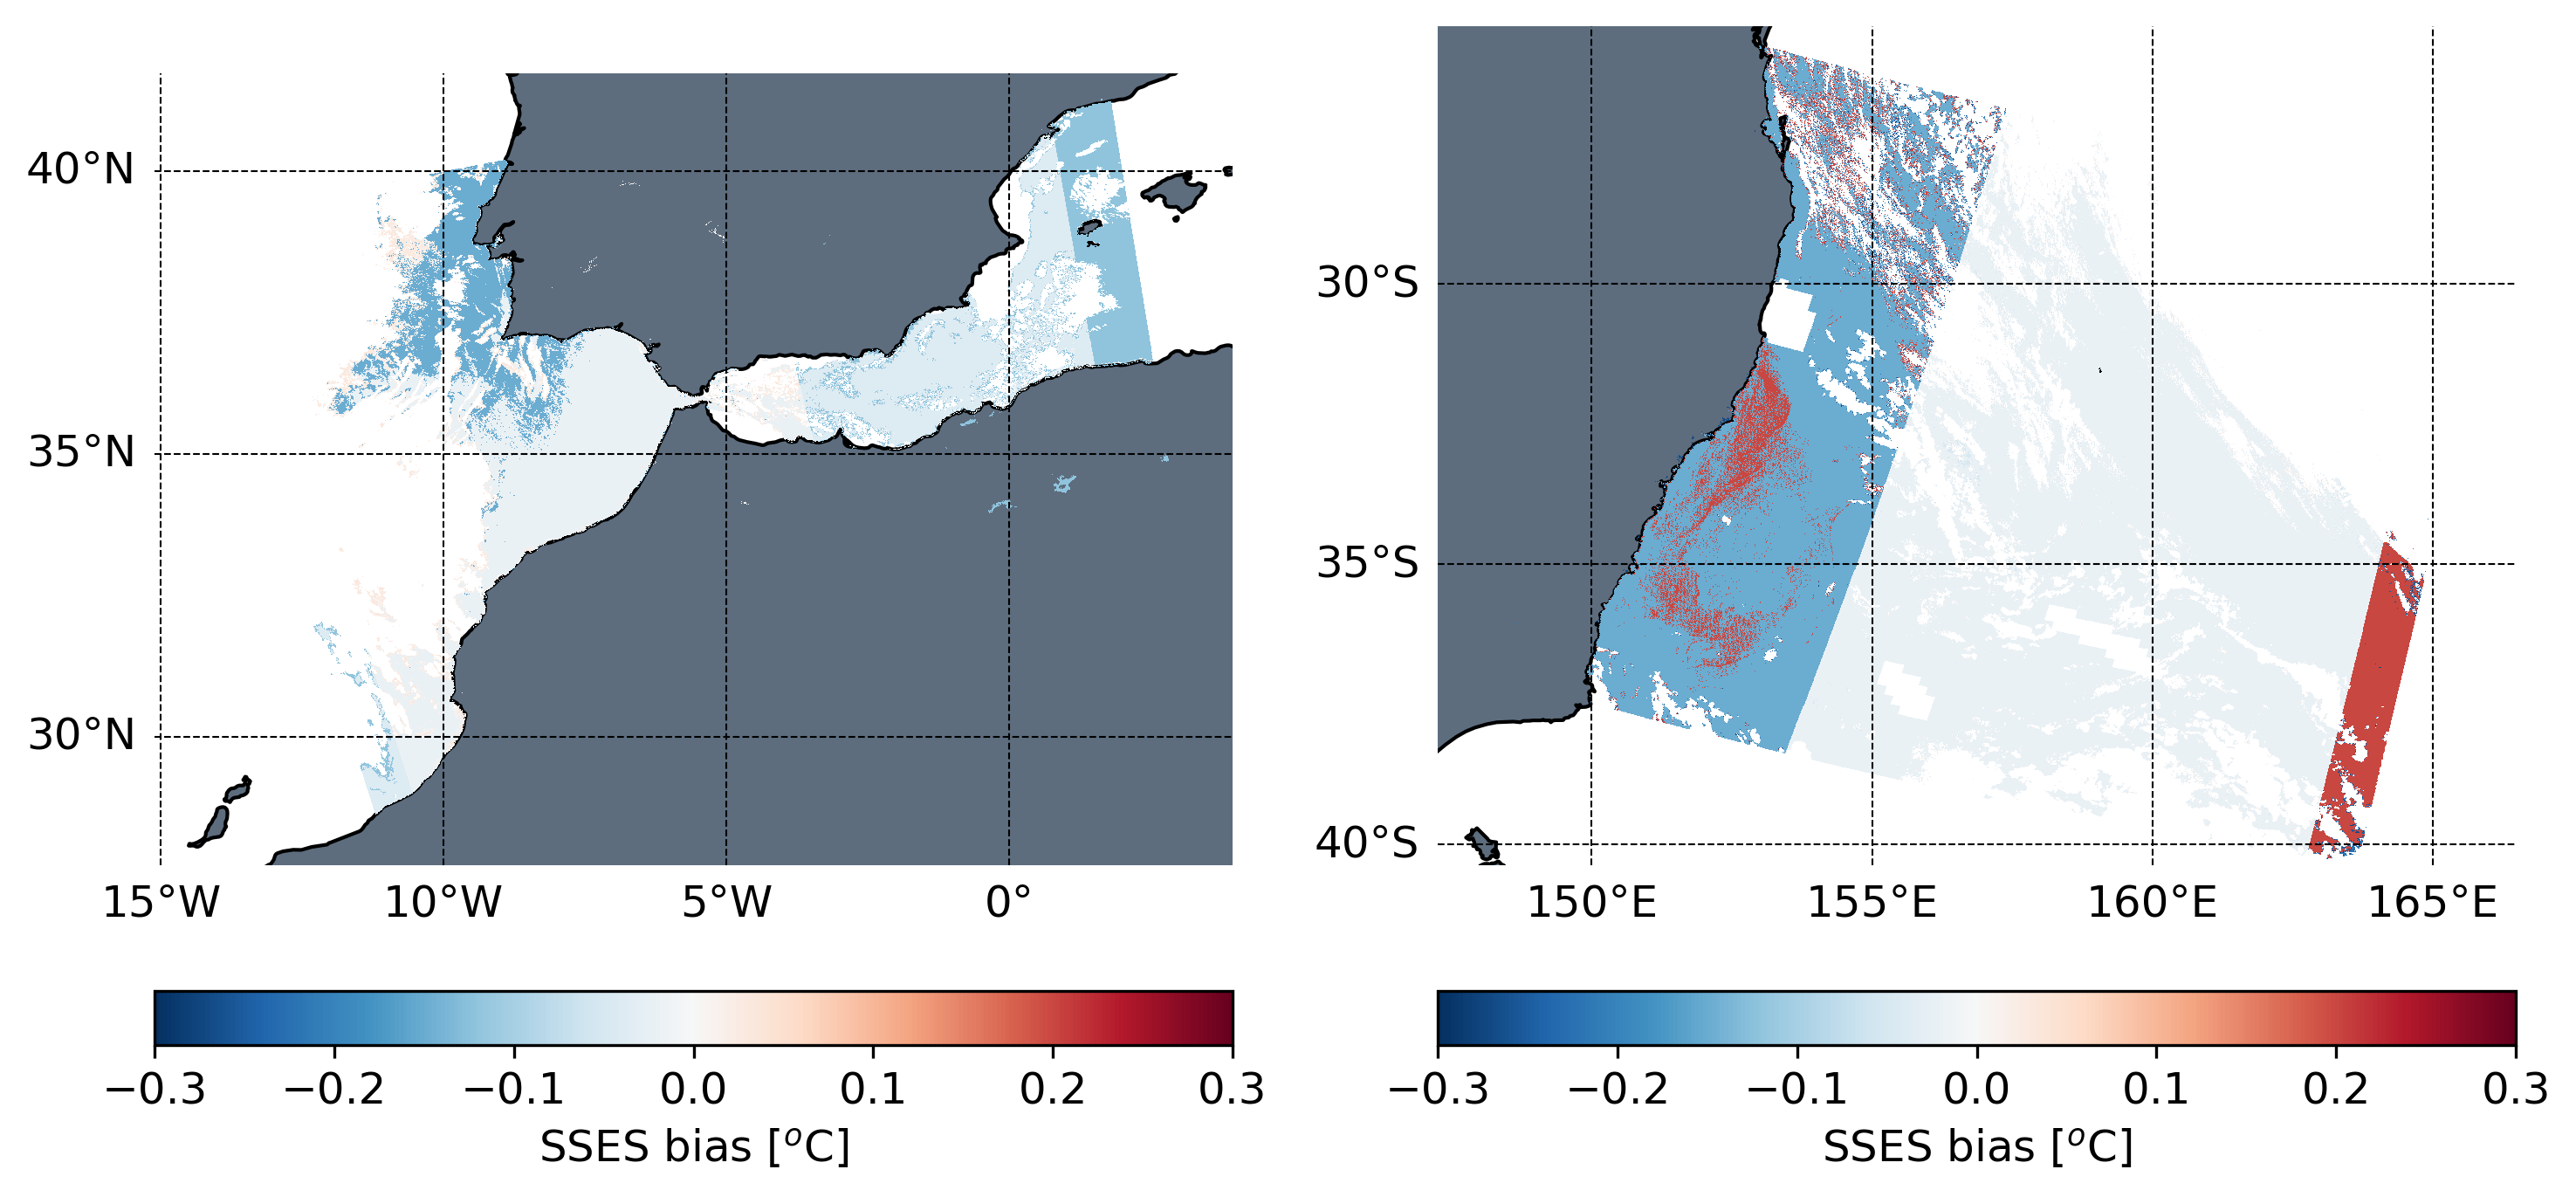

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(10, 10), dpi=300, subplot_kw={"projection": cartopy.crs.PlateCarree()})

for m, loc, vmin, vmax in zip(axs, coords , [-0.3, -0.3], [0.3, 0.3]):
    print(f"Plotting {coords[loc]['name']}")

    # setting "x" to use full swath width
    minx = 0 ; maxx = np.shape(band_vars["lon"])[-1]
    miny = min(coords[loc]["y"]) ; maxy = max(coords[loc]["y"])
    
    pvar = band_vars["sses_bias"][0, miny:maxy, minx:maxx]
    m.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='k', facecolor='#5D6D7E')
    p1 = slstr_plot(m, band_vars, pvar, [minx, maxx, miny, maxy, vmin, vmax], cmap=plt.cm.RdBu_r)
    
    cbar = fig.colorbar(p1, ax=m, location='bottom', pad=0.05)
    cbar.set_label('SSES bias [$^{o}$C]')

plt.tight_layout()

We can see that the bias values change quite significantly when we move between retrieval algorithm, explaining why we have 'striping' in our scene. We can also see that there are regions (e.g. on the western side of the EAC swath), where we have large jumps between bias. This is due to changes in the quality level of the data, which we will discuss below.

<div class="alert alert-info" role="alert">

## <a id='section6'></a>6. Understanding quality levels and applying flags
[Back to top](#TOC_TOP)

</div>

The quality of each pixel in an SLSTR level-2 scene is assessed on a scale of 0 (worst) to 5 (best). Cloud, high aerosol content and poor retrieval algorithm performance all influence the quality level. Usually, it is good practice to use only quality level-5 data, though this can occasionally be relaxed to quality level-4 and above in certain circumstances. We can use the `quality_level` field to check for reliable pixels in our scene, as below.

Plotting Gulf of Cadiz
Plotting East Australian Current


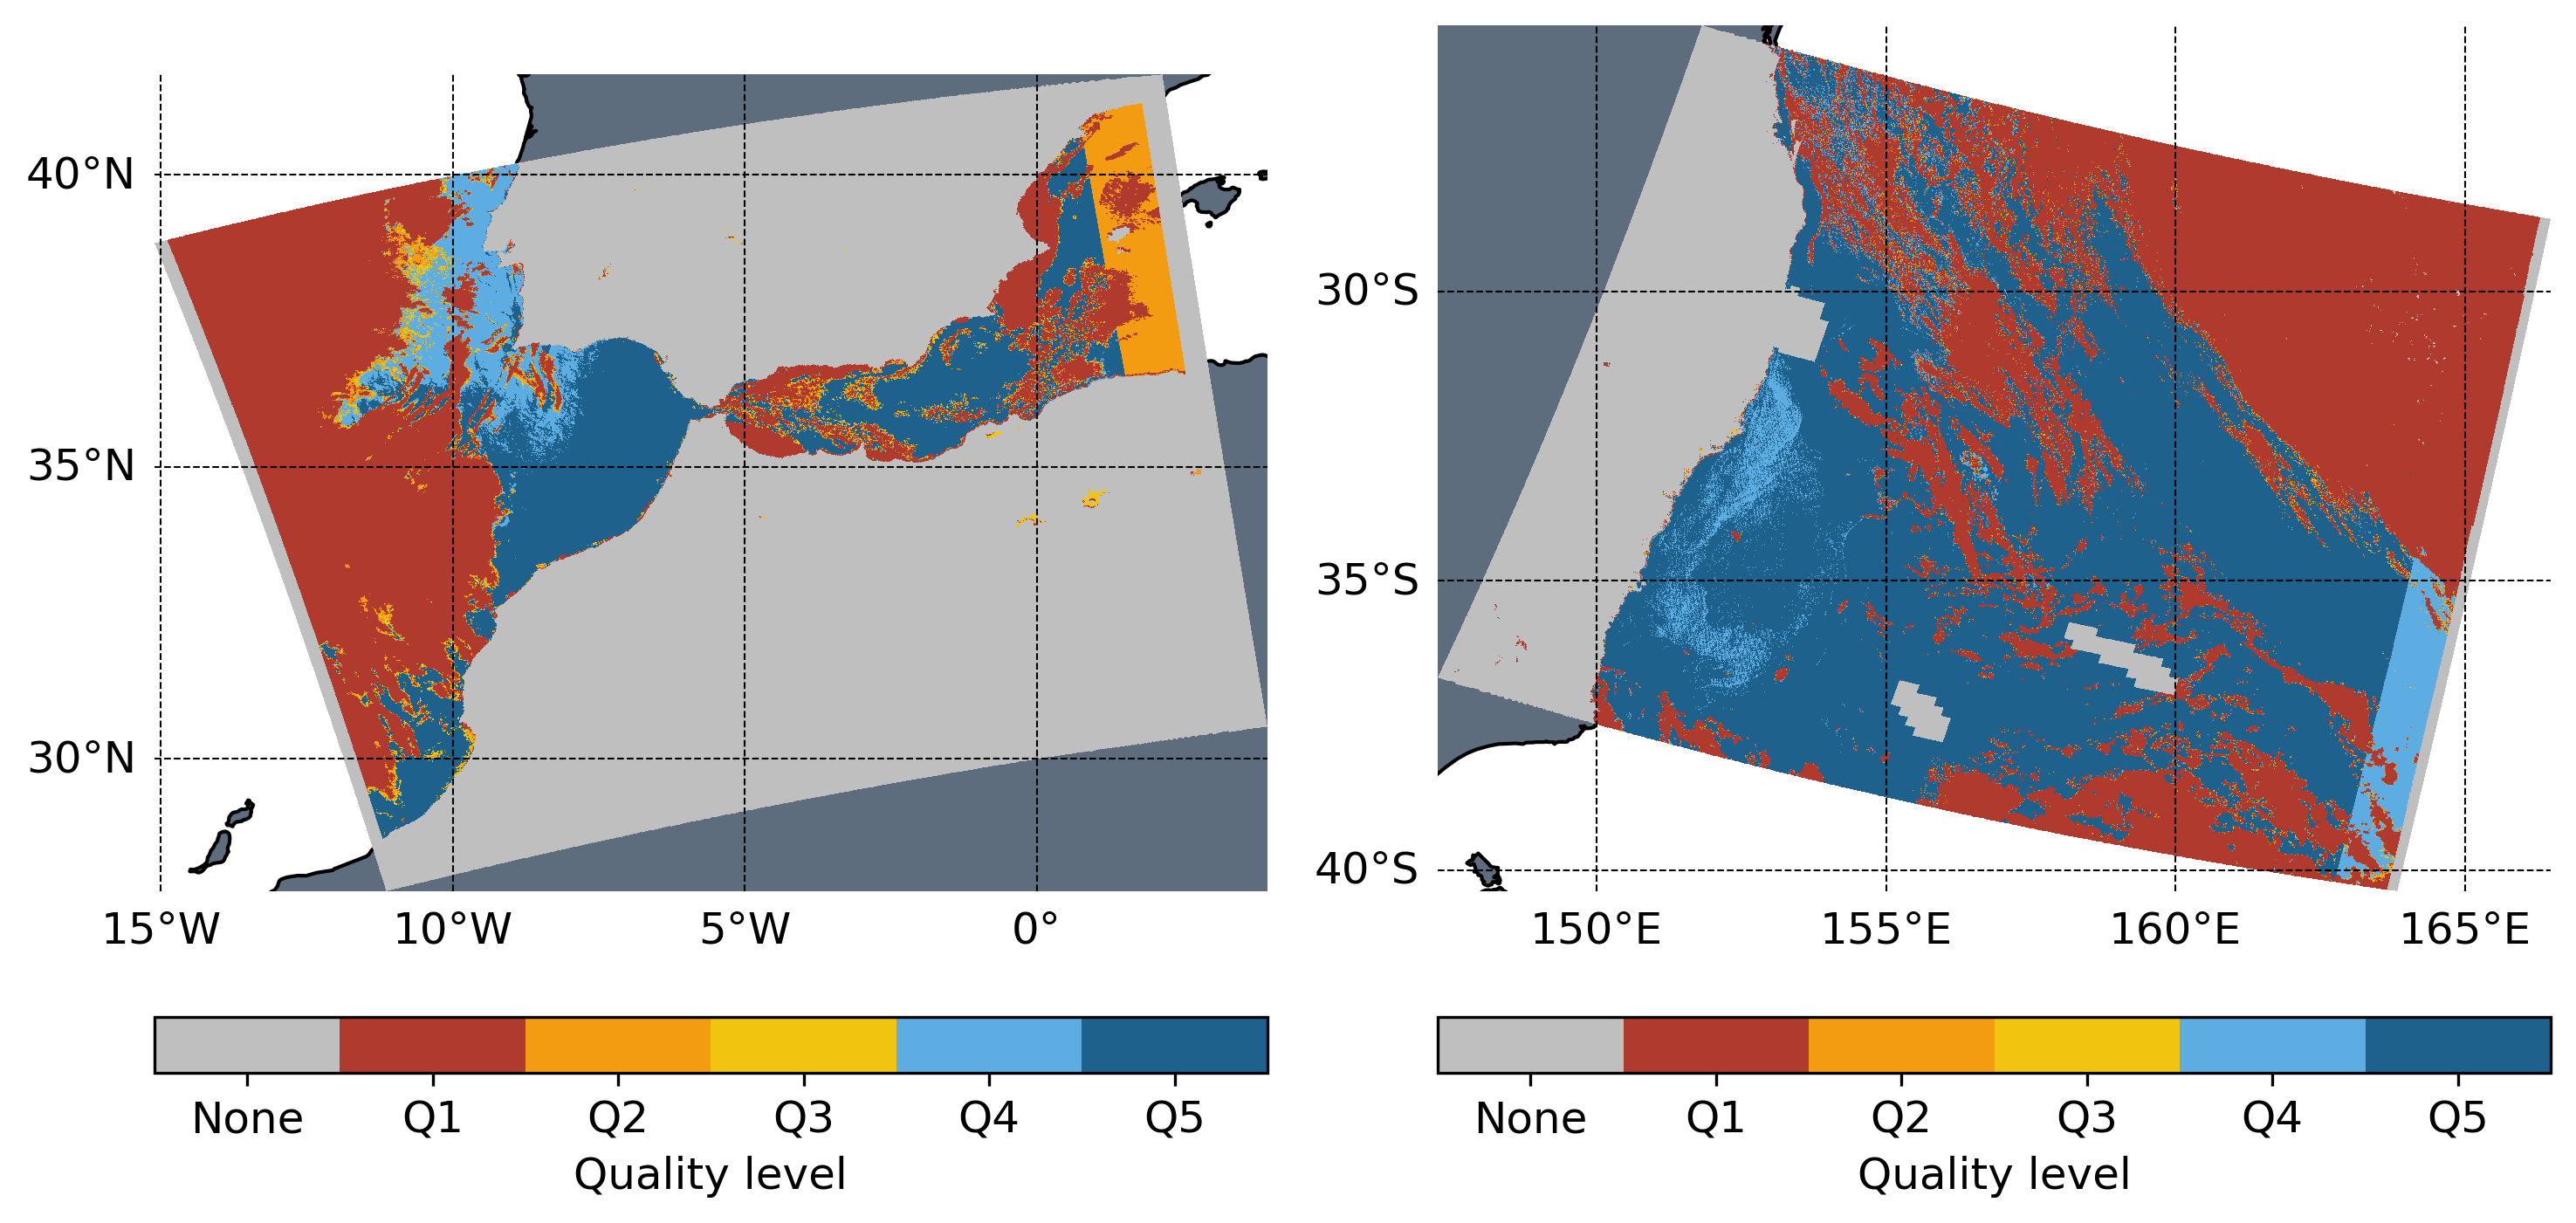

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(10, 10), dpi=300, subplot_kw={"projection": cartopy.crs.PlateCarree()})

for m, loc, vmin, vmax in zip(axs, coords , [0, 0], [6, 6]):
    print(f"Plotting {coords[loc]['name']}")

    # setting "x" to use full swath width
    minx = 0 ; maxx = np.shape(band_vars["lon"])[-1]
    miny = min(coords[loc]["y"]) ; maxy = max(coords[loc]["y"])

    pvar = band_vars["quality_level"][0, miny:maxy, minx:maxx]
    m.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='k', facecolor='#5D6D7E')
    p1 = slstr_plot(m, band_vars, pvar, [minx, maxx, miny, maxy, vmin, vmax], cmap=cmap)

    cbar = fig.colorbar(p1, ax=m, location='bottom', pad=0.05)
    cbar.set_label('Quality level')
    cbar.set_ticks([0.5, 1.5, 2.5, 3.5, 4.5, 5.5])
    cbar.set_ticklabels(['None','Q1','Q2','Q3','Q4','Q5'])
    
plt.tight_layout()

We can clearly see that significant parts of our scene are poor quality, likely due to cloud in this case (Q1). A quality value of "None" is given over land. We also have some lose some data from the eastern side of our GoC scene, likely due to the viewing geometry. If you compare the patterns in the quality level with the sses bias we previously looked at, you can see that one echoes the other as the bias and quality level are linked.

<div class="alert alert-info" role="alert">

## <a id='section7'></a>7. Bringing it all together
[Back to top](#TOC_TOP)

</div>

Finally, we can bring everything we know about SST quality together. Our highest quality SST is:

* measured at night (where possible)
* dual view
* bias corrected
* quality level 5

Lets apply all these factors together and see what data remains (but also plot the day scene for interest).

Plotting Gulf of Cadiz
Plotting East Australian Current


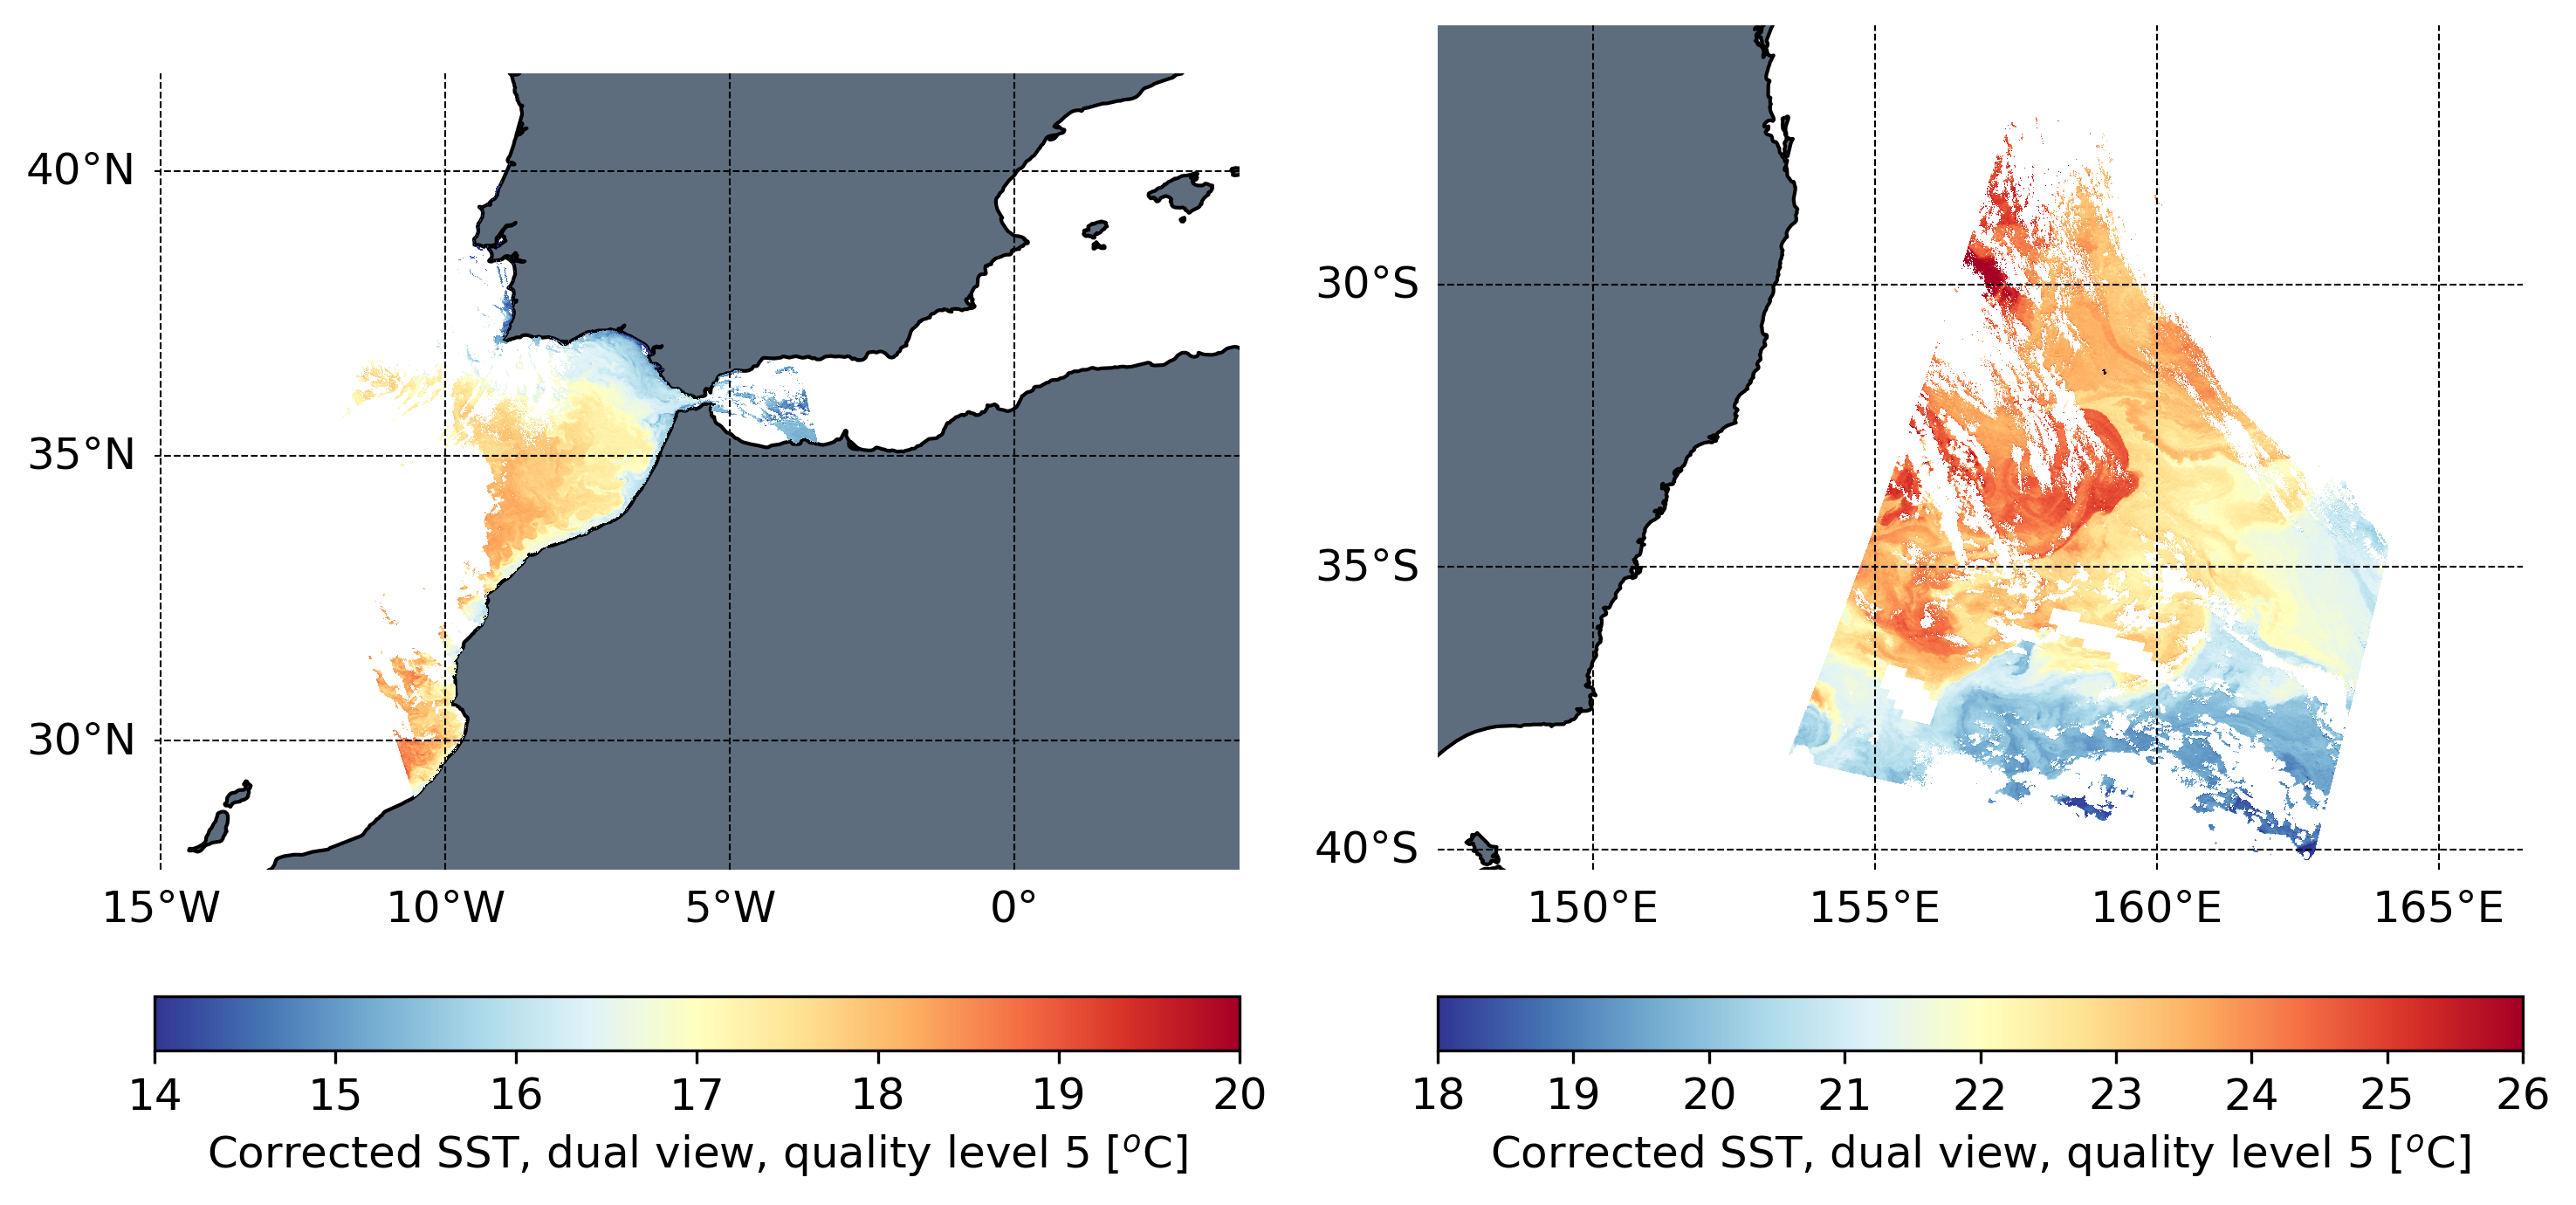

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(10, 10), dpi=300, subplot_kw={"projection": cartopy.crs.PlateCarree()})

for m, loc, vmin, vmax in zip(axs, coords, [14, 18], [20, 26]):
    print(f"Plotting {coords[loc]['name']}")

    # setting "x" to use full swath width
    minx = 0 ; maxx = np.shape(band_vars["lon"])[-1]
    miny = min(coords[loc]["y"]) ; maxy = max(coords[loc]["y"])

    SST = band_vars["sea_surface_temperature"][0, miny:maxy, minx:maxx]
    BIAS = band_vars["sses_bias"][0, miny:maxy, minx:maxx]
    ALGORITHM = band_vars["sst_algorithm_type"][0, miny:maxy, minx:maxx]
    QUAL = band_vars["quality_level"][0, miny:maxy, minx:maxx]
    
    remove_pixels = np.where((ALGORITHM < 4) | (QUAL < 5))
    FINAL_SST = np.array((SST + BIAS) - k_to_c)
    FINAL_SST[remove_pixels] = np.nan
    
    m.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='k', facecolor='#5D6D7E')
    p1 = slstr_plot(m, band_vars, FINAL_SST, [minx, maxx, miny, maxy, vmin, vmax], cmap=plt.cm.RdYlBu_r)

    cbar = fig.colorbar(p1, ax=m, location='bottom', pad=0.05)
    cbar.set_label('Corrected SST, dual view, quality level 5 [$^{o}$C]')
    
plt.tight_layout()

As expected, this costs us a lot of data coverage. However, what remains is of the highest quality. Depending on our application, we may be able to relax certain criteria (e.g. including nadir view).

<hr>
<a href="../Index.ipynb"><< Index</a>
<br>
<a href="./1_5_SLSTR_radiance_BT_spectra.ipynb"><< SLSTR radiance and brightness temperature spectra</a>
<hr>
<a href="https://gitlab.eumetsat.int/eumetlab/ocean" target="_blank">View on GitLab</a> | <a href="https://training.eumetsat.int/" target="_blank">EUMETSAT Training</a> | <a href=mailto:ops@eumetsat.int target="_blank">Contact helpdesk for support </a> | <a href=mailto:Copernicus.training@eumetsat.int target="_blank">Contact our training team to collaborate on and reuse this material</a></span></p>